# Introduction

test With this dataset, we can predict next-day rain by training classification models. It includes 10 years of daily weather data from various locations in Australia. The target variable, **RainTomorrow**, tells us if it will rain the next day (Yes or No). A "Yes" means at least 1mm of rain.

# Importing Libraries

First, we will import the necessary libraries for working with data and downloading it from the internet.

In [ ]:
import math
import io
import zipfile
import requests
from itertools import combinations

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    recall_score,
    auc,
    make_scorer
)

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from joblib import Parallel, delayed

# Data Loading

We will load the data from the provided archive and read it into a DataFrame.

In [ ]:
url = 'https://static.cdn.epam.com/uploads/583f9e4a37492715074c531dbd5abad2/ds/data.%20module%203.%20Classification.zip'

response = requests.get(url)

zip_file = zipfile.ZipFile(io.BytesIO(response.content))

data = pd.read_csv(zip_file.open('data. module 3. Classification/weatherAUS.csv'))

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# EDA

Let's display basic information about the dataset.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Takeaway. The dataset contains 145,460 rows and 23 columns. There are 16 numerical features (float64) and 7 categorical features (object).

Let's get summary statistics for numerical columns.

In [ ]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


Takeaway. The average rainfall is 2.36 mm, but the median (50%) is 0 mm, meaning many days are rain-free. Max rainfall hits 371 mm — a clear outlier that we should check later.

Let's check for missing values in each column.

In [ ]:
print(data.isnull().sum())

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


Takeaway. Some columns, like Evaporation, Sunshine, Cloud9am and Cloud3pm are missing a lot of values. This is something we'll need to deal with later.

The column RainTomorrow, which we’re predicting, has 3,267 missing values. We’ll have to handle this carefully since it’s our main focus.

## Univariate Analysis

Let's visualize the distribution of each numerical feature using histograms. These histograms help us understand the distribution of each feature—whether they're normally distributed, skewed or have outliers.

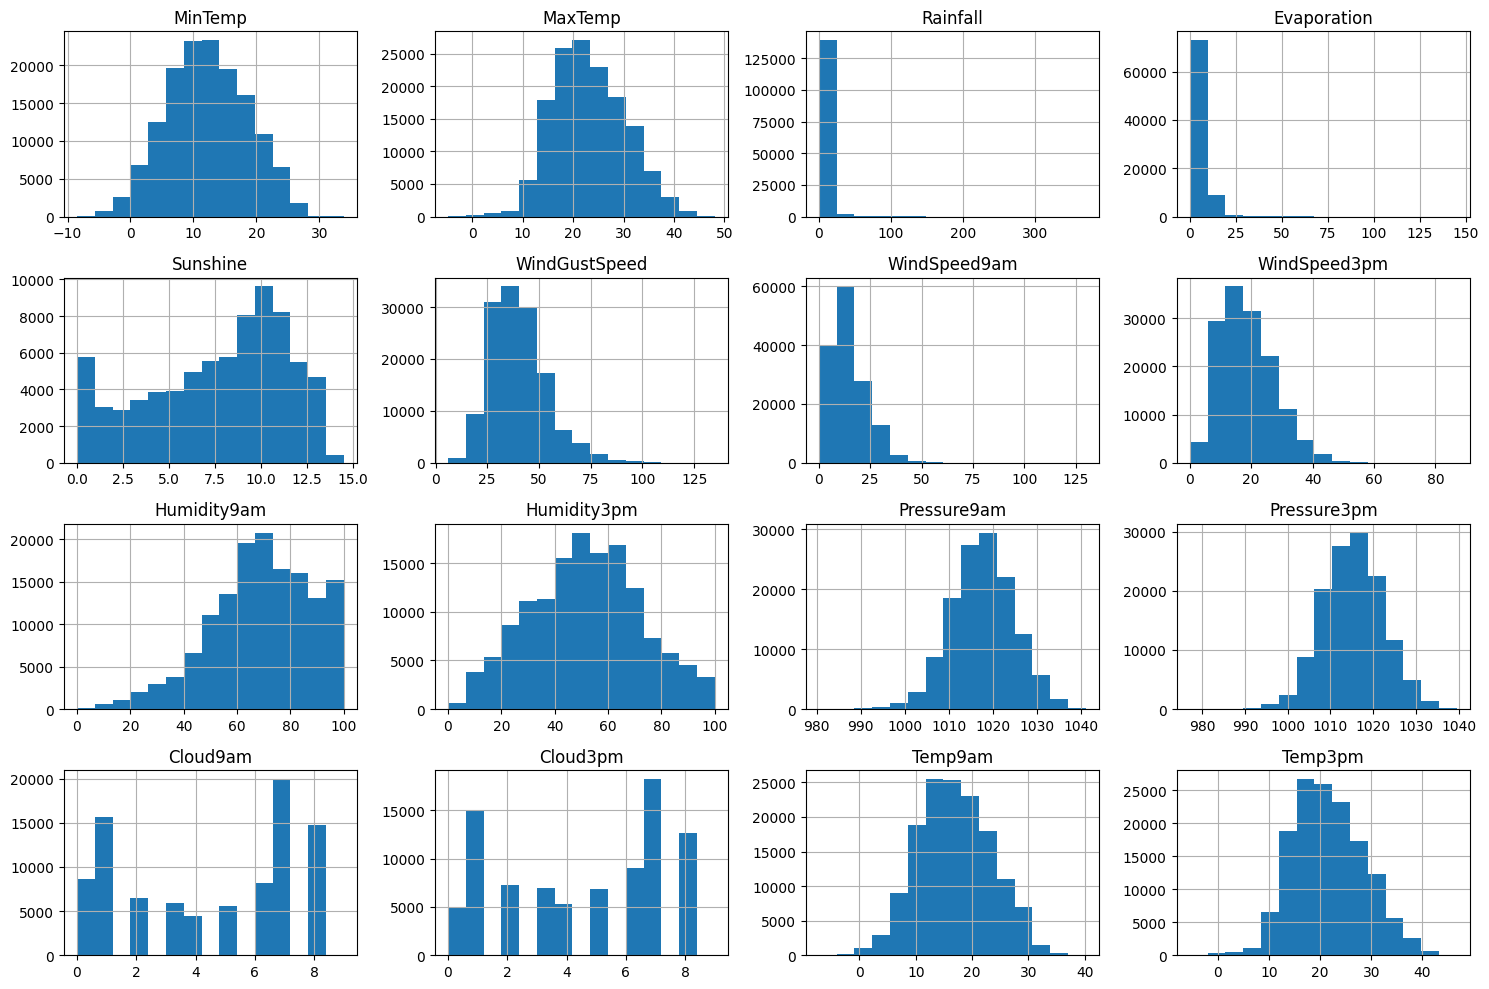

In [ ]:
numerical_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                      'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                      'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                      'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

data[numerical_features].hist(bins=15, figsize=(15, 10))
plt.tight_layout()
plt.show()

Takeaway. Rainfall is skewed — most days are dry, but a few extreme outliers (max 371 mm).

Boxplots can help us spot outliers in the data.

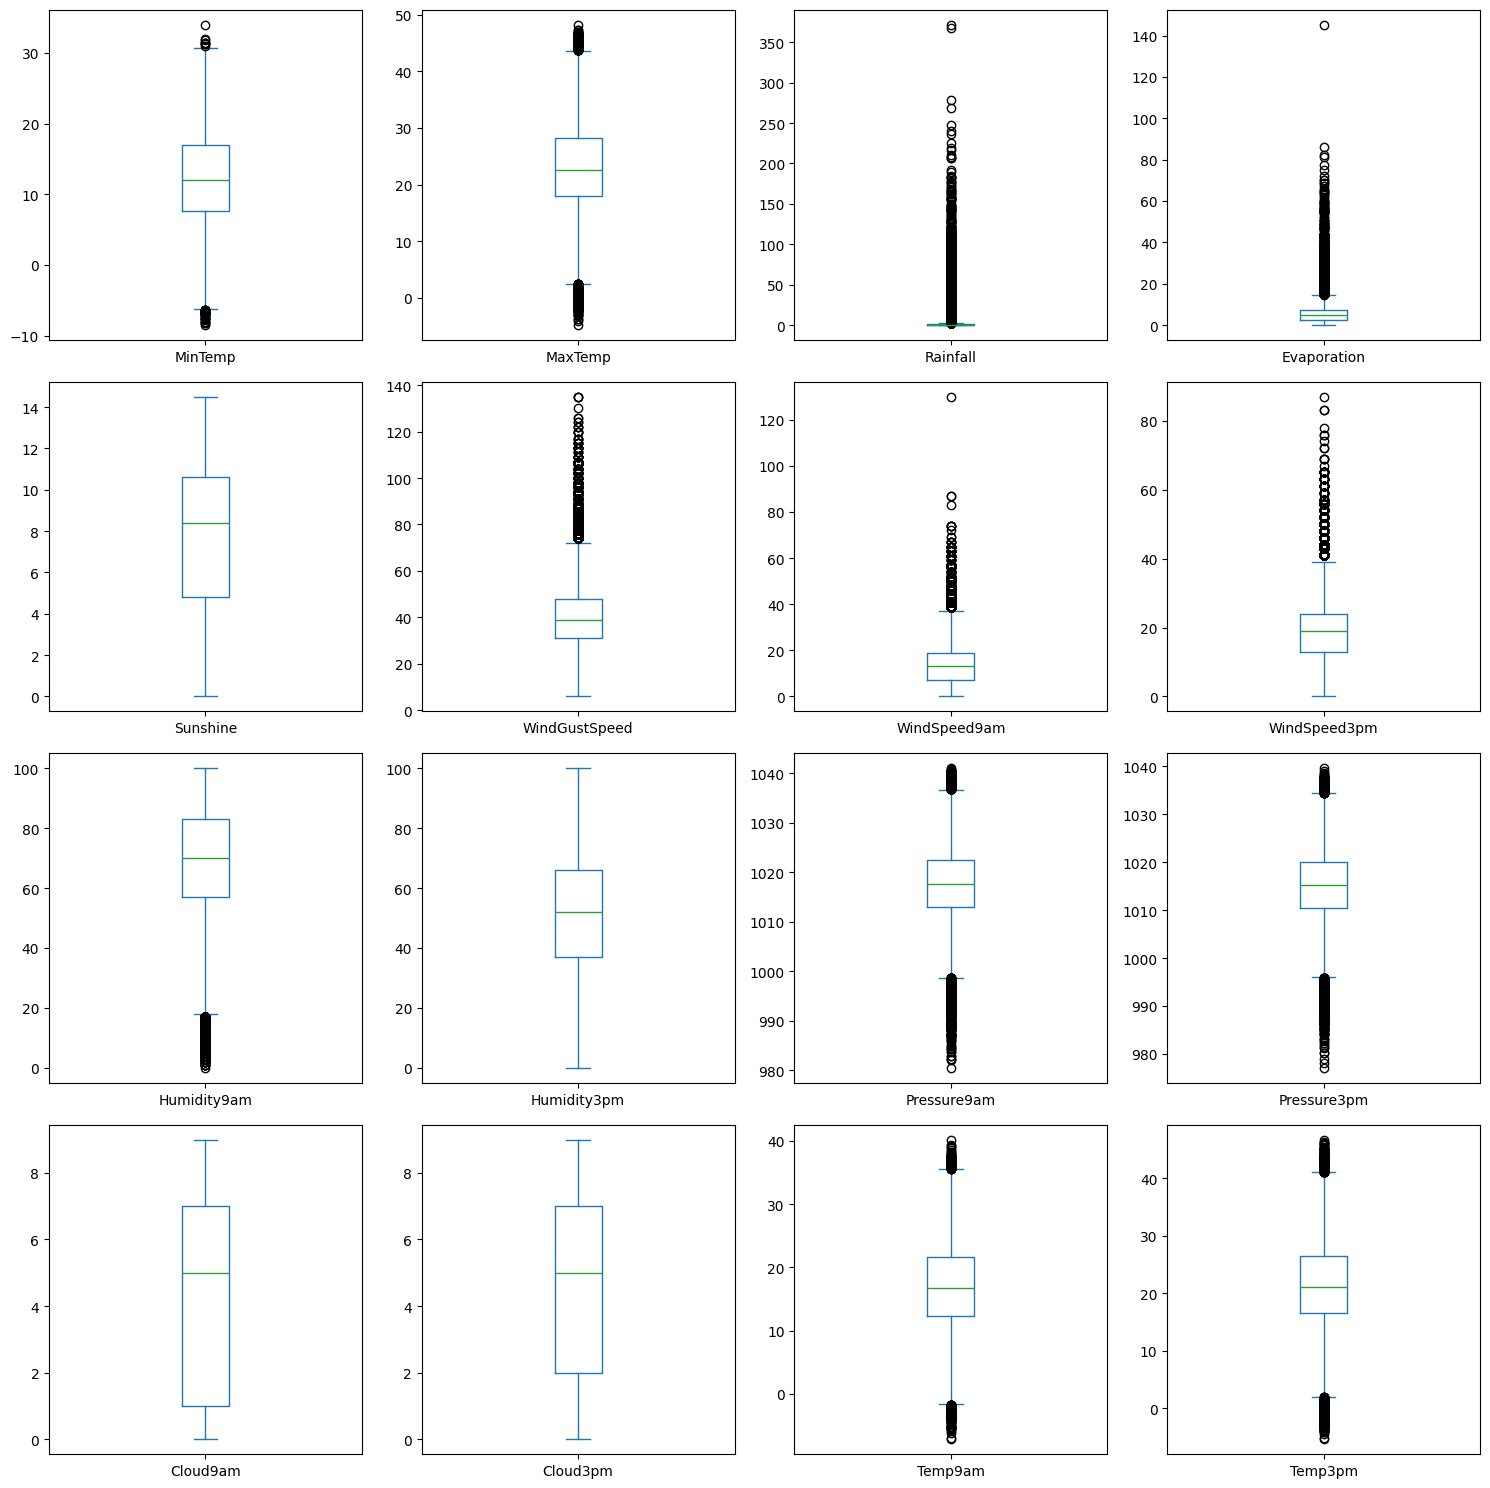

In [ ]:
data[numerical_features].plot(kind='box', subplots=True, layout=(4,4), figsize=(15,15))
plt.tight_layout()
plt.show()

Takeaway. Boxplots show lots of extreme values outside the normal range. Outliers could impact predictions. We’ll need to decide on outliers.

## Multivariate Analysis

We'll explore relationships between pairs of features with correlation matrix.

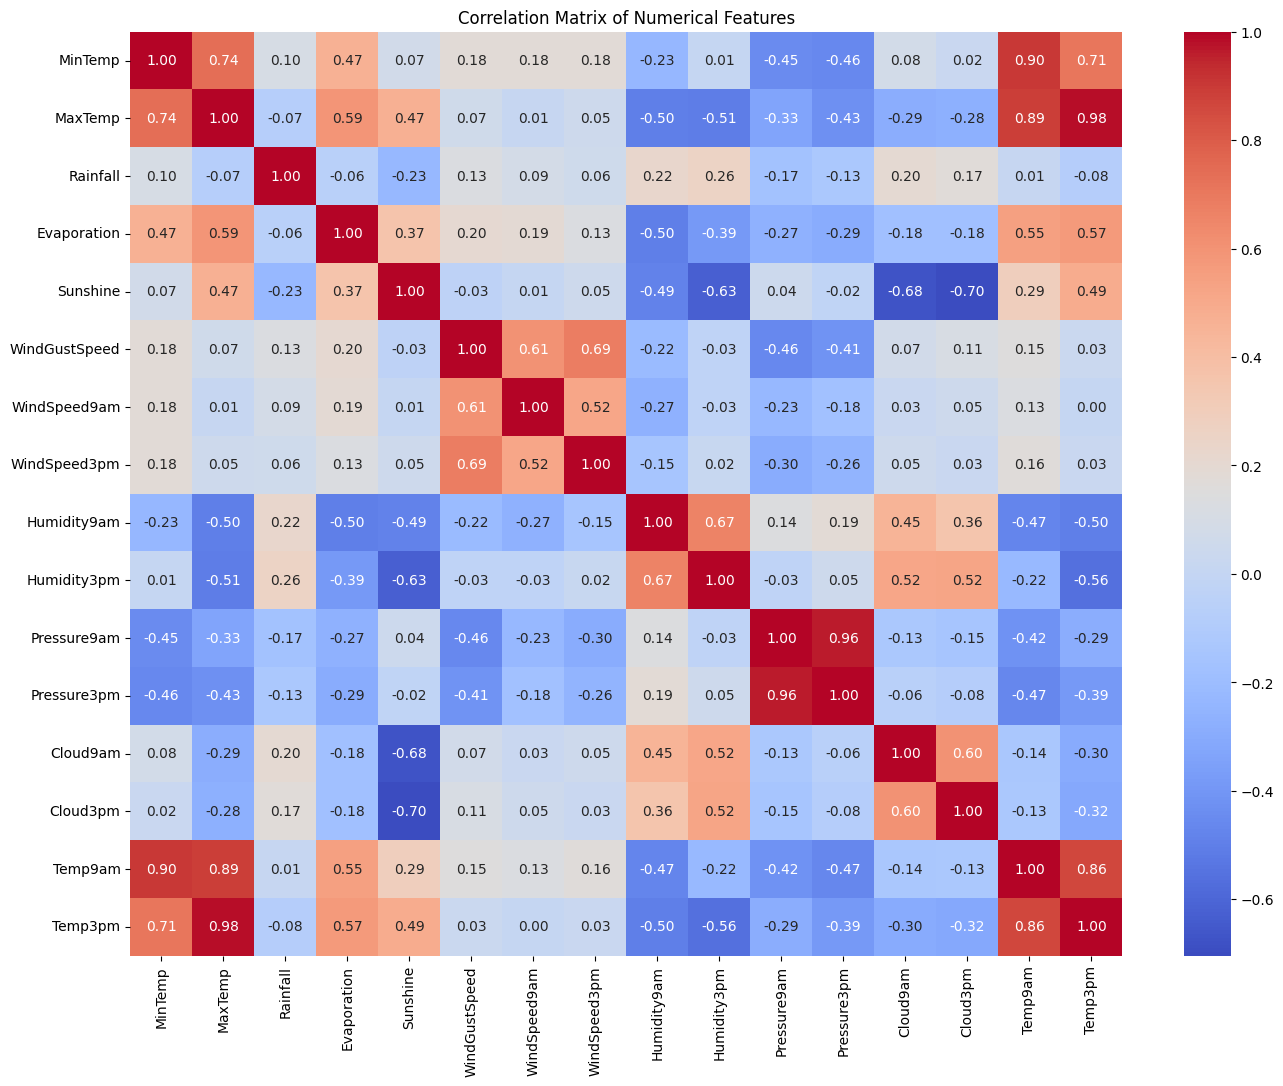

In [ ]:
corr_matrix = data[numerical_features].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Takeaway. MinTemp and MaxTemp are highly correlated (0.74). Pressure9am and Pressure3pm are nearly identical (0.96). Rainfall has weak correlations (max 0.22 with Humidity9am). Temp9am and Temp3pm are strongly correlated (0.86).

Let's perform pairwise analysis.

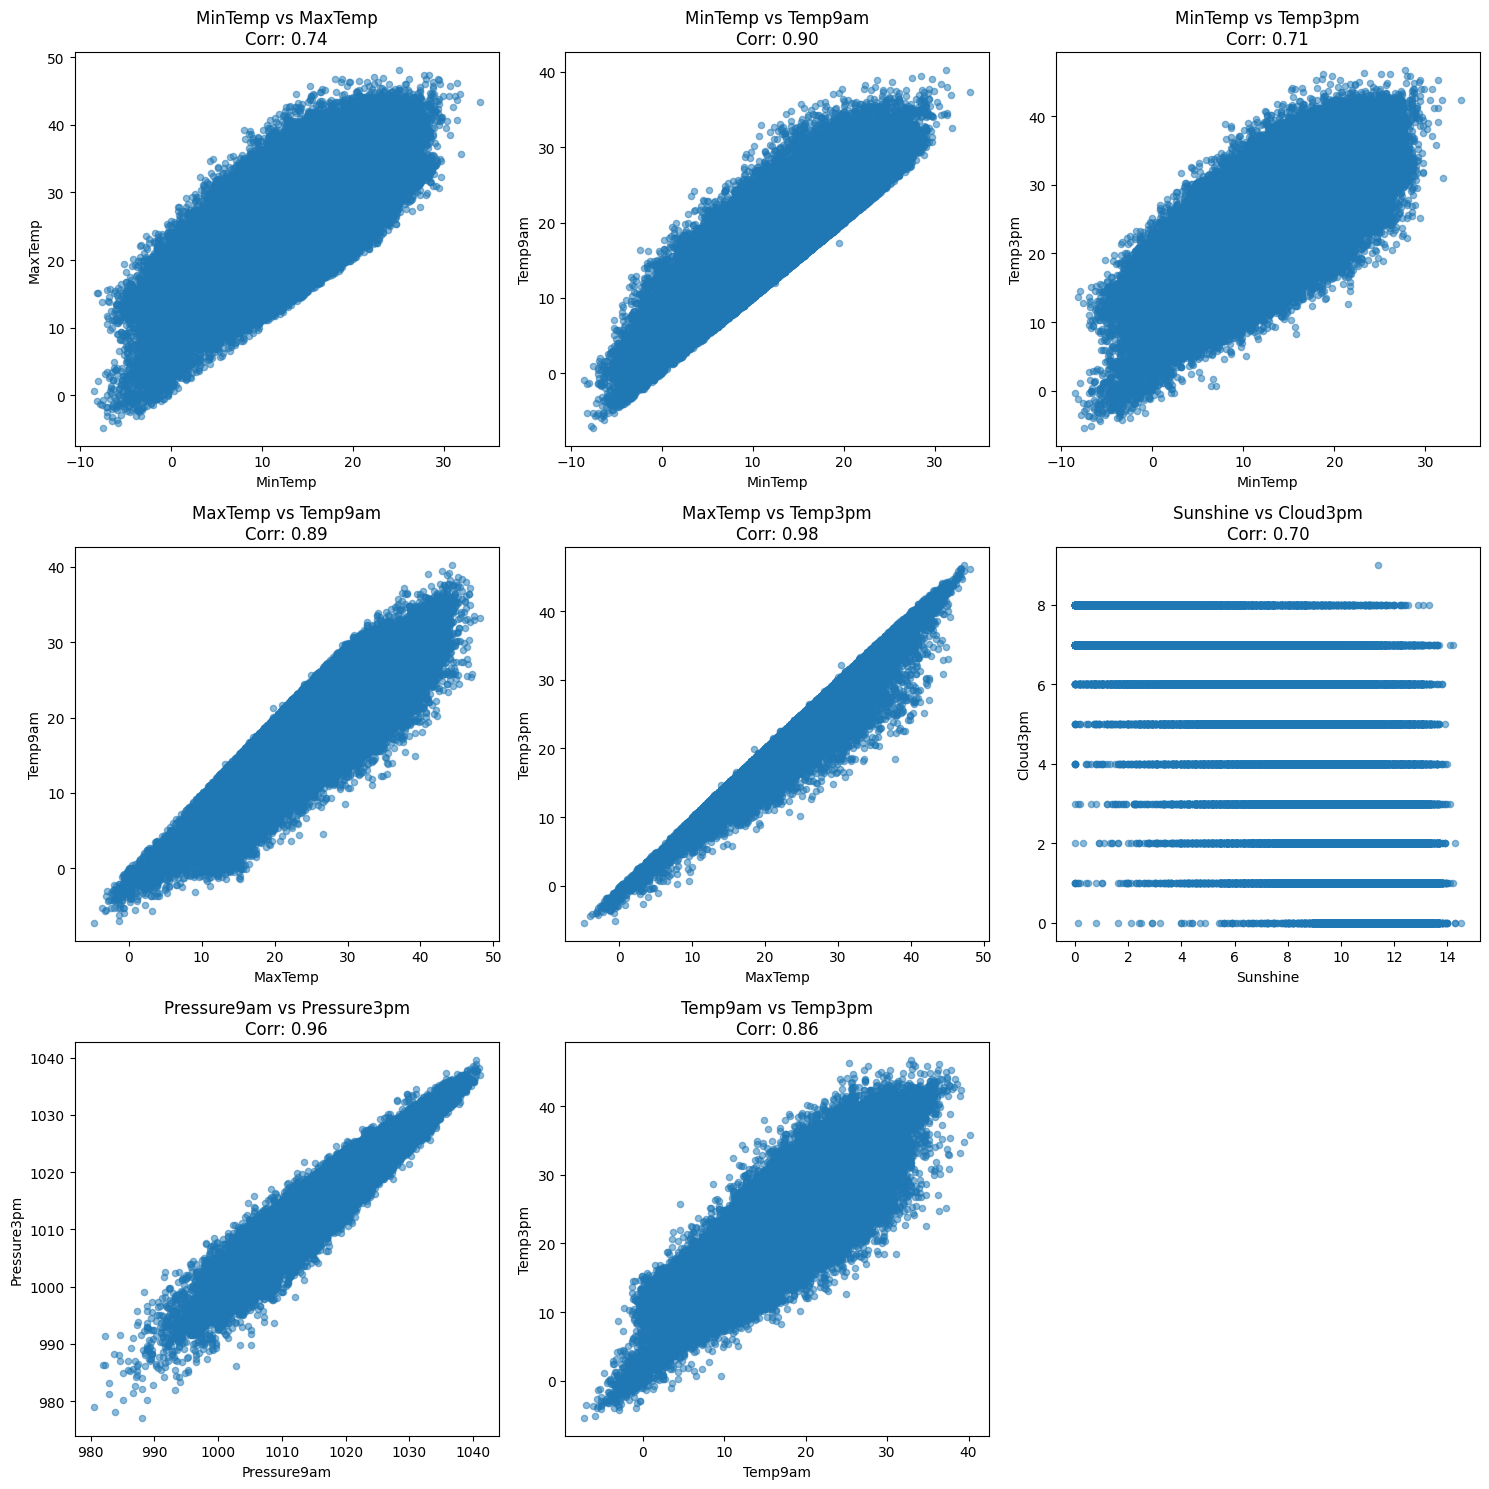

In [ ]:
def pairwise_analysis(df, features, corr_threshold=0.5):
    corr = df[features].corr().abs()
    pairs = [(x, y, corr.loc[x, y]) for x, y in combinations(features, 2) if corr.loc[x, y] >= corr_threshold]
    if not pairs:
        print("No feature pairs meet the correlation threshold.")
        return
    rows, cols = math.ceil(len(pairs)/3), 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()
    for ax, (x, y, c) in zip(axes, pairs):
        df.plot.scatter(x=x, y=y, ax=ax, alpha=0.5)
        ax.set_title(f'{x} vs {y}\nCorr: {c:.2f}')
    for ax in axes[len(pairs):]:
        fig.delaxes(ax)
    plt.tight_layout()
    plt.show()

pairwise_analysis(data, numerical_features, corr_threshold=0.7)

We'll quantify multicollinearity using the Variance Inflation Factor (VIF).

In [ ]:
df_numeric = data[numerical_features].dropna()

vif_data = pd.DataFrame()
vif_data['Feature'] = df_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(df_numeric.values, i) for i in range(len(df_numeric.columns))]

print(vif_data)

          Feature            VIF
0         MinTemp      57.771637
1         MaxTemp     607.991535
2        Rainfall       1.275486
3     Evaporation       7.093298
4        Sunshine      17.266083
5   WindGustSpeed      26.356228
6    WindSpeed9am       7.773498
7    WindSpeed3pm      13.484718
8     Humidity9am      60.768992
9     Humidity3pm      47.911125
10    Pressure9am  425138.207608
11    Pressure3pm  423321.049957
12       Cloud9am       7.412763
13       Cloud3pm       8.373254
14        Temp9am     208.432280
15        Temp3pm     673.514479


Takeaway. Redundant features can negatively affect various models. In logistic regression, they may lead to unstable coefficients, making the model harder to interpret. For KNN, redundant information can distort distance calculations, impacting prediction accuracy. In the case of Naive Bayes, feature redundancy violates the independence assumption, reducing the reliability of the model. For SVM, redundant data can complicate the optimization and ultimately degrade the model's performance.

Let's implement feature selection by removing the features with high multicollinearity.

In [ ]:
features_to_drop = ['MinTemp', 'Temp9am', 'Temp3pm', 'Pressure3pm', 'Humidity3pm']

df_reduced = data.drop(columns=features_to_drop)

print(df_reduced.columns)

Index(['Date', 'Location', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am',
       'Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')


Let's see how the VIF values look after dropping these features.

In [ ]:
numerical_features_reduced = ['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                              'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                              'Humidity9am', 'Pressure9am', 'Cloud9am', 'Cloud3pm']

df_numeric_reduced = df_reduced[numerical_features_reduced].dropna()

vif_data_reduced = pd.DataFrame()
vif_data_reduced['Feature'] = df_numeric_reduced.columns
vif_data_reduced['VIF'] = [variance_inflation_factor(df_numeric_reduced.values, i) for i in range(len(df_numeric_reduced.columns))]

print(vif_data_reduced)

          Feature        VIF
0         MaxTemp  26.475683
1        Rainfall   1.245891
2     Evaporation   6.674372
3        Sunshine  15.887924
4   WindGustSpeed  25.034986
5    WindSpeed9am   7.211980
6    WindSpeed3pm  12.585374
7     Humidity9am  27.887407
8     Pressure9am  92.489380
9        Cloud9am   7.041515
10       Cloud3pm   7.991573


Takeaway. Our models should now be more stable and interpretable.

***Nice section, 5/5***

# Data Preparation

To prevent data leakage, we'll scale the data **after** performing the train-test split. This ensures that information from the test set doesn't influence the training process.

## Defining Features and Target

First, we'll define our target variable `y` and feature set `X`.

In [ ]:
y = data['RainTomorrow']
X = data.drop(columns=['RainTomorrow'])

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (145460, 22)
Shape of y: (145460,)


## Extracting Meaningful Time-Based Features

Instead of dropping the `Date` column, we'll extract meaningful time-based features such as `Year`, `Month`, `Day`, and `DayOfWeek`. This allows the model to capture temporal patterns without being overwhelmed by the high cardinality of the original `Date` feature.

In [ ]:
X['Date'] = pd.to_datetime(X['Date'])
X['Year'] = X['Date'].dt.year
X['Month'] = X['Date'].dt.month
X['Day'] = X['Date'].dt.day
X['DayOfWeek'] = X['Date'].dt.dayofweek  # Monday=0, Sunday=6

X = X.drop(columns=['Date'])
print(f"Shape after extracting time-based features and dropping 'Date': X: {X.shape}")
X.head()

Shape after extracting time-based features and dropping 'Date': X: (145460, 25)


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Month,Day,DayOfWeek
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,2008,12,1,0
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,2008,12,2,1
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,2008,12,3,2
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,2008,12,4,3
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,2008,12,5,4


## Dropping Rows with Missing Target

We'll remove any rows where the target variable `RainTomorrow` is missing to ensure a clean split.

In [ ]:
missing_target = y.isnull()
X = X[~missing_target]
y = y[~missing_target]

print(f"Shape after dropping missing targets: X: {X.shape}, y: {y.shape}")

Shape after dropping missing targets: X: (142193, 25), y: (142193,)


## Dropping Rows with Missing Features

We'll remove any rows in `X` that have missing feature values to allow the train-test split to proceed without errors.

In [ ]:
missing_features = X.isnull().any(axis=1)
X = X[~missing_features]
y = y[~missing_features]

print(f"Shape after dropping missing features: X: {X.shape}, y: {y.shape}")

Shape after dropping missing features: X: (56420, 25), y: (56420,)


***This is most probably a huge mistake. Just because you don't have some values of features filled it is unreasonable to drop an entire row. First of all, the absence of data can tell us something. Secondly, and most importantly, everything in data science depends on data. Better data >>> better models. Data is your gold and it is highly unrecommended to drop almost 2/3 of your data. Keep that in mind.***

## Sorting the Data by Time-Based Features

To perform a time-based train-test split, we'll sort the data chronologically based on the extracted time-based features.

In [ ]:
data_sorted = X.copy()
data_sorted['RainTomorrow'] = y

data_sorted = data_sorted.sort_values(by=['Year', 'Month', 'Day']).reset_index(drop=True)

print(f"Shape after sorting: {data_sorted.shape}")
data_sorted.head()

Shape after sorting: (56420, 26)


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Month,Day,DayOfWeek,RainTomorrow
0,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,SW,NW,...,7.0,7.0,14.4,23.6,No,2007,11,1,3,Yes
1,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,E,W,...,5.0,3.0,17.5,25.7,Yes,2007,11,2,4,Yes
2,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,N,NNE,...,8.0,7.0,15.4,20.2,Yes,2007,11,3,5,Yes
3,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,WNW,W,...,2.0,7.0,13.5,14.1,Yes,2007,11,4,6,Yes
4,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,SSE,ESE,...,7.0,7.0,11.1,15.4,Yes,2007,11,5,0,No


## Spliting the Data

We'll perform a time-based split, using the first 80% of the data for training and the remaining 20% for testing. This approach prevents data leakage and ensures that the model is evaluated on future data.

In [ ]:
split_index = int(0.8 * len(data_sorted))
X_train = data_sorted.iloc[:split_index].drop(columns=['RainTomorrow'])
y_train = data_sorted.iloc[:split_index]['RainTomorrow']
X_test = data_sorted.iloc[split_index:].drop(columns=['RainTomorrow'])
y_test = data_sorted.iloc[split_index:]['RainTomorrow']

print(f"\nTraining set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training set shape: X_train: (45136, 25), y_train: (45136,)
Test set shape: X_test: (11284, 25), y_test: (11284,)


## Handling Outliers

We'll handle outliers using the IQR method **only** on the training set and apply the same boundaries to the test set.

In [ ]:
def handle_outliers(X_train, X_test, features):
    for feature in features:
        Q1 = X_train[feature].quantile(0.25)
        Q3 = X_train[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        X_train[feature] = np.clip(X_train[feature], lower_bound, upper_bound)
        X_test[feature] = np.clip(X_test[feature], lower_bound, upper_bound)
    return X_train, X_test

In [ ]:
numerical_features_outliers = ['MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                                'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                                'Humidity9am', 'Pressure9am', 'Cloud9am', 'Cloud3pm',
                                'Year', 'Month', 'Day', 'DayOfWeek']

X_train, X_test = handle_outliers(X_train, X_test, numerical_features_outliers)

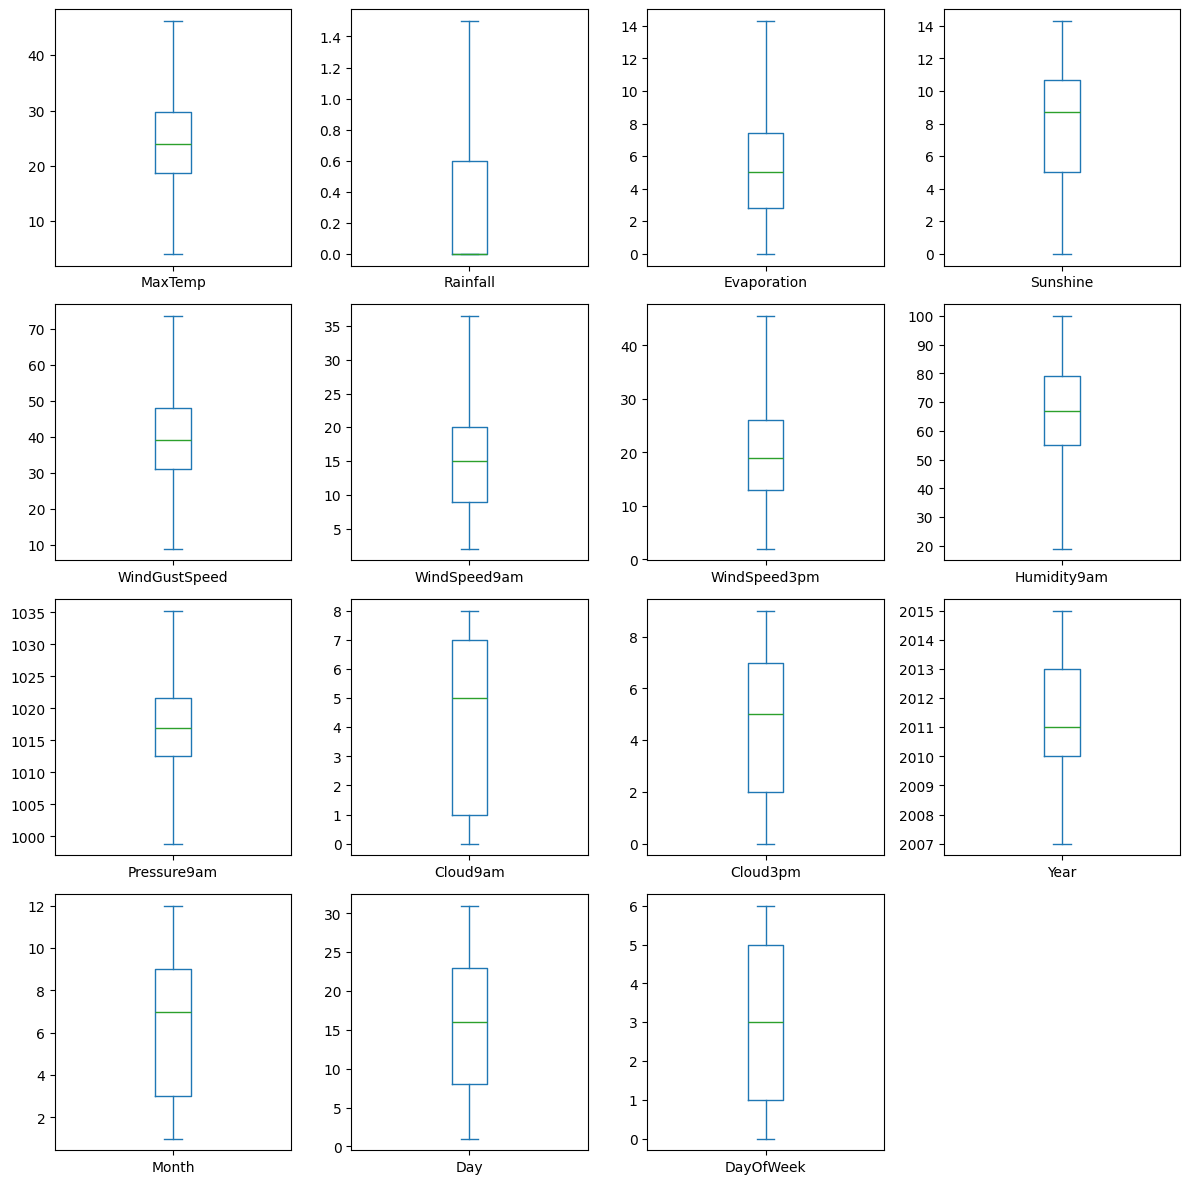

In [ ]:
X_train[numerical_features_outliers].plot(kind='box', subplots=True, layout=(4, 4), figsize=(12, 12))
plt.tight_layout()
plt.show()

Takeaway. Handling outliers using the IQR method has eliminated extreme values in the boxplots, which enhanced the quality of the dataset for model training, potentially leading to better generalization and performance. Interestingly, how clean boxplots have become.

## Encoding Categorical Variables

We'll handle categorical variables by frequency encoding for 'Location' and One-Hot Encoding for other categorical features.

In [ ]:
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:")
print(categorical_features)

if 'Location' in categorical_features:
    location_counts = X_train['Location'].value_counts()
    X_train['Location_Freq'] = X_train['Location'].map(location_counts)
    X_test['Location_Freq'] = X_test['Location'].map(location_counts).fillna(0)
    X_train = X_train.drop(columns=['Location'])
    X_test = X_test.drop(columns=['Location'])
    categorical_features.remove('Location')

print("After frequency encoding 'Location':")
print(X_train[['Location_Freq']].head())

X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)

X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print("Columns after one-hot encoding:")
print(X_train_encoded.columns)

Categorical features:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
After frequency encoding 'Location':
   Location_Freq
0           1078
1           1078
2           1078
3           1078
4           1078
Columns after one-hot encoding:
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day', 'DayOfWeek',
       'Location_Freq', 'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N',
       'WindGustDir_NE', 'WindGustDir_NNE', 'WindGustDir_NNW',
       'WindGustDir_NW', 'WindGustDir_S', 'WindGustDir_SE', 'WindGustDir_SSE',
       'WindGustDir_SSW', 'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW',
       'WindGustDir_WSW', 'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N',
       'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW',
 

***Just because the data type is "object" does not mean it is suitable for being one-hot encoded. First of all, check and prove to yourself that the given "object" columns are indeed categorical. Even though in your case the one-hot encoding is suitable for all of "object" columns, don't forget to check them. Moreover, in future keep in mind that OHE creates a column for each unique value in the given column, making our dataset wide and sparse. If the number of unique values is too huge, then it will make any calculations computationally expensive. So you have to preliminary check the number of unique values of each column you apply OHE to.***

## Scaling Numerical Features

We'll scale numerical features using `StandardScaler`. We'll fit the scaler on the training data and apply it to both training and testing sets.

In [ ]:
numerical_features_final = X_train_encoded.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()

X_train_encoded[numerical_features_final] = scaler.fit_transform(X_train_encoded[numerical_features_final])
X_test_encoded[numerical_features_final] = scaler.transform(X_test_encoded[numerical_features_final])

print("Summary statistics after scaling (Training set):")
print(X_train_encoded[numerical_features_final].describe().round(2))

Summary statistics after scaling (Training set):
        MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
count  45136.00  45136.00  45136.00     45136.00  45136.00       45136.00   
mean       0.00     -0.00     -0.00        -0.00      0.00           0.00   
std        1.00      1.00      1.00         1.00      1.00           1.00   
min       -3.12     -2.89     -0.63        -1.63     -2.05          -2.52   
25%       -0.76     -0.80     -0.63        -0.79     -0.73          -0.78   
50%       -0.03     -0.05     -0.63        -0.12      0.25          -0.14   
75%        0.78      0.79      0.35         0.60      0.78           0.57   
max        2.79      3.16      1.83         2.68      1.73           2.59   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  Pressure3pm  \
count      45136.00      45136.00     45136.00     45136.00  ...     45136.00   
mean           0.00          0.00         0.00         0.00  ...        -0.00   
std           

## Defining Final Feature Sets

Now, we'll define our final feature sets `X_train_final` and `X_test_final`, and ensure that our target variable `y_train` and `y_test` are properly encoded.

In [ ]:
y_train = y_train.map({'No': 0, 'Yes': 1})
y_test = y_test.map({'No': 0, 'Yes': 1})

X_train_final = X_train_encoded
X_test_final = X_test_encoded

print(f"\nFinal Training set shape: X_train_final: {X_train_final.shape}, y_train: {y_train.shape}")
print(f"Final Test set shape: X_test_final: {X_test_final.shape}, y_test: {y_test.shape}")

print("\nMissing values in target variable:")
print(y_train.isnull().sum(), y_test.isnull().sum())


Final Training set shape: X_train_final: (45136, 67), y_train: (45136,)
Final Test set shape: X_test_final: (11284, 67), y_test: (11284,)

Missing values in target variable:
0 0


***Overall, good enough section. But please keep in mind the comments you received. Before dropping your data make sure you cannot act otherwise. 3/5***

# Modeling

Now that our data is properly prepared without data leakage, we can proceed to build and evaluate our models.

## Logistic Regression

### Training

We'll create an instance of the Logistic Regression model and fit it to the training data.

In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_final, y_train)

LogisticRegression(max_iter=1000)

### Evaluation

Now, we'll make predictions on the test set and evaluate the model's performance.

In [ ]:
y_pred = logreg.predict(X_test_final)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      8811
           1       0.72      0.50      0.59      2473

    accuracy                           0.85     11284
   macro avg       0.80      0.72      0.75     11284
weighted avg       0.84      0.85      0.84     11284



The model is good at predicting "No Rain" (high precision).

The model struggles to predict "Rain" correctly (low recall). The model missed many rainy days, predicting "No rain."

### Hyperparameters Tuning

We'll use GridSearchCV to find the best hyperparameters for our Logistic Regression model.

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_final, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

best_logreg = grid_search.best_estimator_

y_pred_best = best_logreg.predict(X_test_final)
print("Classification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      8811
           1       0.72      0.50      0.59      2473

    accuracy                           0.85     11284
   macro avg       0.80      0.72      0.75     11284
weighted avg       0.84      0.85      0.84     11284



Model still struggles to predict "Rain" correctly (low recall). The model missed many rainy days, predicting "No rain."

***Why did you choose those hyperparameters? Why did you choose 'accuracy' as scoring? 8/10***

### Feature Importance

Let's look at the coefficients of the logistic regression model to understand which features are most influential.

In [ ]:
feature_names = X_train_final.columns
coefficients = best_logreg.coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coef_df['Importance'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Importance', ascending=False)

print("Top features influencing the prediction:")
print(coef_df.head(10))

Top features influencing the prediction:
           Feature  Coefficient  Importance
9      Humidity3pm     1.199297    1.199297
11     Pressure3pm    -1.176857    1.176857
5    WindGustSpeed     0.821234    0.821234
10     Pressure9am     0.795120    0.795120
4         Sunshine    -0.588222    0.588222
40  WindDir9am_NNE     0.414119    0.414119
13        Cloud3pm     0.269750    0.269750
43    WindDir9am_S    -0.269537    0.269537
2         Rainfall     0.250920    0.250920
39   WindDir9am_NE     0.245736    0.245736


***I would recommend using SHAP or permutation feature importance to find out if the features are important. Listing of coefficients does no represent reality all the time.***

### Plot Feature Importance

Let's plot feature importance.

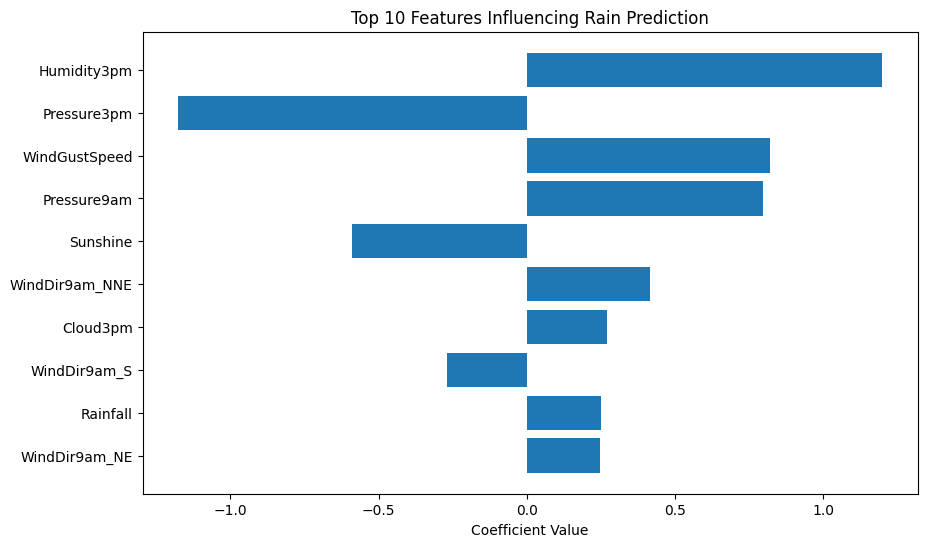

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'][:10], coef_df['Coefficient'][:10])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Features Influencing Rain Prediction')
plt.gca().invert_yaxis()
plt.show()

Takeaway. Humidity and wind are significant predictors of rain.
Wind direction influences rain probability.
Pressure is inversely related to rain chance.

***Few comments of feature importance interpretability. "Pressure is inversely related to rain chance." is not fully valid argument. 4/5***

### Threshold Analysis

By default, the decision threshold is 0.5. But we can tune it to improve recall.

Optimal Threshold: 0.1920355822574977


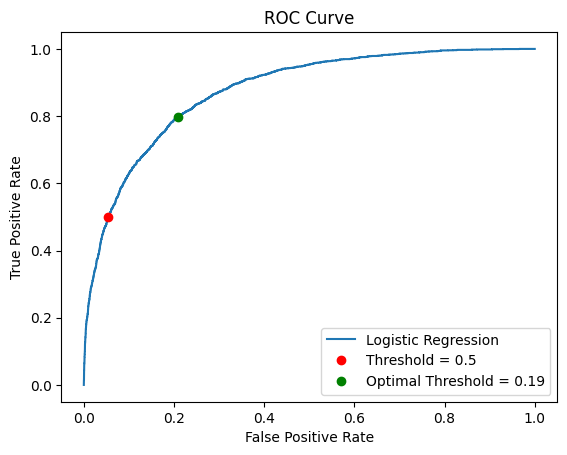

              precision    recall  f1-score   support

           0       0.93      0.79      0.86      8811
           1       0.52      0.80      0.63      2473

    accuracy                           0.79     11284
   macro avg       0.73      0.80      0.74     11284
weighted avg       0.84      0.79      0.81     11284



In [ ]:
y_probs = best_logreg.predict_proba(X_test_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

threshold_0_5_index = np.argmin(np.abs(thresholds - 0.5))
fpr_0_5 = fpr[threshold_0_5_index]
tpr_0_5 = tpr[threshold_0_5_index]

J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print('Optimal Threshold:', best_threshold)

fpr_optimal = fpr[ix]
tpr_optimal = tpr[ix]

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot(fpr_0_5, tpr_0_5, 'ro', label='Threshold = 0.5')
plt.plot(fpr_optimal, tpr_optimal, 'go', label=f'Optimal Threshold = {best_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

y_pred_optimal = (y_probs >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_optimal))

Takeaway. Lowering the threshold improves the model's ability to detect rain days (higher recall).
This comes at the cost of more false alarms (lower precision).
This trade-off may be acceptable, because for weather forecasting, missing a rain prediction might be worse than a false alarm.
Class imbalance affects model performance. Fewer "Rain" days compared to "No Rain" days.

***Nicely done. But here for some reason you use J statistic to find the best threshold. Why not largest recall or AUC or precision or f-measure points? 4/5***

### Metrics chosen and reasoning

• Accuracy: Useful, but can be misleading because of imbalanced data.

• Recall (Sensitivity): Of all the rainy days, how many did we successfully detect. Important to minimize missed rainy days (false negatives).

• Precision: Out of all the days the model predicted rain, how many actually rained. This comes at the cost of more false alarms (false positives).

• ROC-AUC Score: Measures the model's ability to distinguish between classes across all thresholds.

• Youden's J statistic: The threshold that maximizes the difference between TPR and FPR.

In rain prediction, it's essential to focus on recall to ensure we detect as many rainy days as possible, minimizing missed predictions.

***Metrics chosen and reasoning should be a separate section. Your reasoning for choosing the metrics is good. One thing you don't mention is that the dataset can be imbalanced in terms of target distribution. This case accuracy is indeed a misleading metric. Please keep in mind that choice of the most suitable metric can be a way to handle imbalanced classes. Additionally, when dealing with precision-recall compromise you should think of f-measures as well. 5/5***

## KNN

### Training, Evaluation, Hyperparameters Tuning

We'll test different values of k and observe how they affect the recall for the "Rain Tomorrow" class.

In [ ]:
k_values = range(1, 21)

knn = KNeighborsClassifier(n_neighbors=max(k_values), n_jobs=-1)
knn.fit(X_train_final, y_train)

distances, indices = knn.kneighbors(X_test_final, n_neighbors=max(k_values))

recall_scores = []

for k in k_values:
    y_pred = np.array([np.bincount(y_train[indices[i, :k]], minlength=2).argmax() for i in range(len(X_test_final))])
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)
    print(f"k={k}, Recall={recall:.4f}")

k=1, Recall=0.4650
k=2, Recall=0.2762
k=3, Recall=0.4501
k=4, Recall=0.3296
k=5, Recall=0.4387
k=6, Recall=0.3453
k=7, Recall=0.4270
k=8, Recall=0.3530
k=9, Recall=0.4214
k=10, Recall=0.3623
k=11, Recall=0.4108
k=12, Recall=0.3672
k=13, Recall=0.4036
k=14, Recall=0.3647
k=15, Recall=0.3967
k=16, Recall=0.3639
k=17, Recall=0.3963
k=18, Recall=0.3639
k=19, Recall=0.3918
k=20, Recall=0.3635


Takeaway. By parallelizing the KNN loop, we significantly reduce the total computation time required to evaluate different `k` values.

***You still can use Grid or other search here instead of custom looping.***

### k Value vs Recall

Let's plot recall vs k.

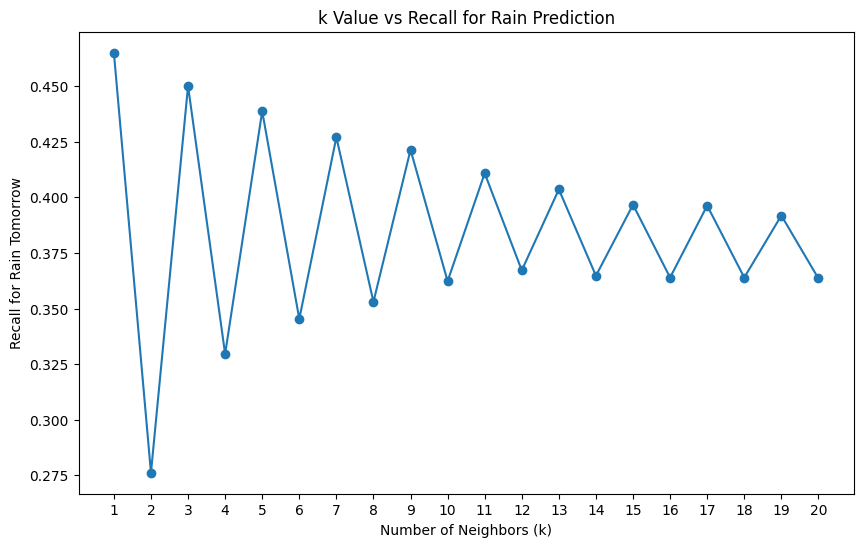

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, recall_scores, marker='o')
plt.title('k Value vs Recall for Rain Prediction')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Recall for Rain Tomorrow')
plt.xticks(k_values)
plt.show()

Let's select the best k based on recall.

In [ ]:
best_k = k_values[recall_scores.index(max(recall_scores))]
print(f"Best k value based on recall: {best_k}")

knn_best = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn_best.fit(X_train_final, y_train)
y_pred_best = knn_best.predict(X_test_final)
print(f"Classification Report for k={best_k}:")
print(classification_report(y_test, y_pred_best))

Best k value based on recall: 1
Classification Report for k=1:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      8811
           1       0.51      0.47      0.49      2473

    accuracy                           0.78     11284
   macro avg       0.68      0.67      0.67     11284
weighted avg       0.78      0.78      0.78     11284



Takeaway. By focusing on recall and testing different k values in parallel, we tailored the KNN model to better predict rainy days. Although a lower k may introduce more false alarms, it aligns with our priority of not missing rain predictions.

***Good, 10/10***

## Naive Bayes

### Training, Evaluation, Hyperparameters Tuning

We'll create an instance of the Naive Bayes classifier and train it using our training data.

In [ ]:
nb = GaussianNB()
nb.fit(X_train_final, y_train)

GaussianNB()

Now, we'll make predictions on the test set and evaluate the performance.

In [ ]:
y_pred = nb.predict(X_test_final)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred))

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      8811
           1       0.46      0.69      0.55      2473

    accuracy                           0.75     11284
   macro avg       0.68      0.73      0.69     11284
weighted avg       0.80      0.75      0.77     11284



Takeaway. The model favors "No Rain" predictions, with higher precision and recall for that class. Performance for detecting rain is moderate but has many false alarms.

Let's tune 'var_smoothing' for GaussianNB with GridSearchCV to maximize Recall.

In [ ]:
scorer = make_scorer(recall_score)
param_grid = {'var_smoothing': np.logspace(-9, 0, 10)}
grid = GridSearchCV(GaussianNB(), param_grid, scoring=scorer, cv=5)
grid.fit(X_train_final, y_train)
print(f"Best Recall: {grid.best_score_:.4f}")
print(f"Best Parameters: {grid.best_params_}")

Best Recall: 0.7113
Best Parameters: {'var_smoothing': 0.1}


We'll retrain the model with the best var_smoothing value.

In [ ]:
best_smoothing = grid.best_params_['var_smoothing']
nb_best = GaussianNB(var_smoothing=best_smoothing)
nb_best.fit(X_train_final, y_train)
y_pred_best = nb_best.predict(X_test_final)
print("Naive Bayes Classification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

Naive Bayes Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      8811
           1       0.52      0.65      0.58      2473

    accuracy                           0.79     11284
   macro avg       0.71      0.74      0.72     11284
weighted avg       0.81      0.79      0.80     11284



Takeaway. The model performs good at predicting "No Rain" with higher precision and recall but still struggles with "Rain," showing moderate recall.

***Why only var_smoothing as hyperparameter to optimize? Overall, good, 9/10***

## SVM

### Training, Evaluation, Hyperparameters Tuning

We'll start by training an SVM with default parameters.

In [ ]:
svm = LinearSVC()
svm.fit(X_train_final, y_train)

LinearSVC()

Let's evaluate the model.

In [ ]:
y_pred = svm.predict(X_test_final)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      8811
           1       0.73      0.48      0.58      2473

    accuracy                           0.85     11284
   macro avg       0.80      0.72      0.74     11284
weighted avg       0.84      0.85      0.84     11284



Takeaway. The SVM model performs well in predicting "No Rain" with high precision and recall but struggles with detecting "Rain" correctly (low recall).

We'll perform a GridSearchCV to find the best hyperparameter.

In [ ]:
linear_svc = LinearSVC()
calibrated_svc = CalibratedClassifierCV(linear_svc, cv=3)
param_grid = {
    'estimator__C': [0.1, 1, 10],
}
grid_search = GridSearchCV(
    calibrated_svc,
    param_grid=param_grid,
    cv=3,
    scoring='recall',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train_final, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Hyperparameters: {'estimator__C': 10}


Let's use the best model with optimized hyperparameter from GridSearchCV.

In [ ]:
svm_best = grid_search.best_estimator_
y_pred_best = svm_best.predict(X_test_final)
print("SVM Classification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

SVM Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      8811
           1       0.73      0.49      0.58      2473

    accuracy                           0.85     11284
   macro avg       0.80      0.72      0.75     11284
weighted avg       0.84      0.85      0.84     11284



Takeaway. The SVM model predicts "No Rain" well but struggles significantly with "Rain," achieving low recall (32%) for rainy days.

***Again only one hyperparameter, 9/10***

# ROC AUC

In [ ]:
def plot_roc_auc(model, X_test, y_test, model_name="Model"):
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_probs = model.decision_function(X_test)
        y_probs = 1 / (1 + np.exp(-y_probs))
    else:
        print(f"{model_name} does not support probability predictions.")
        return

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})", color='blue')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"AUC for {model_name}: {auc_score:.2f}")

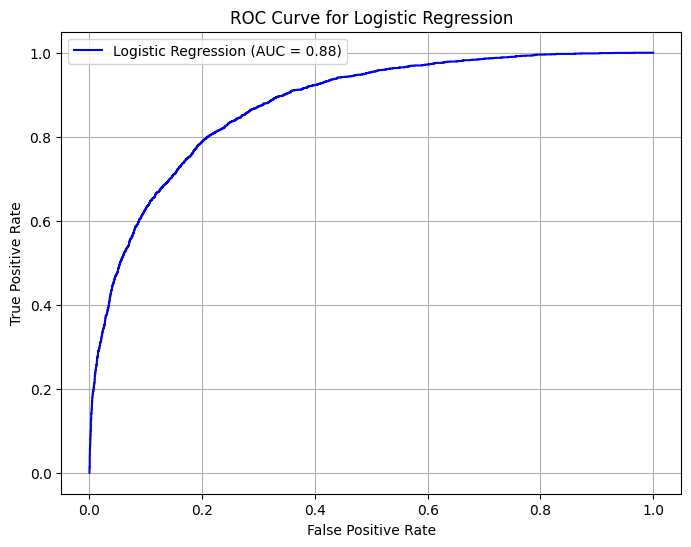

AUC for Logistic Regression: 0.88


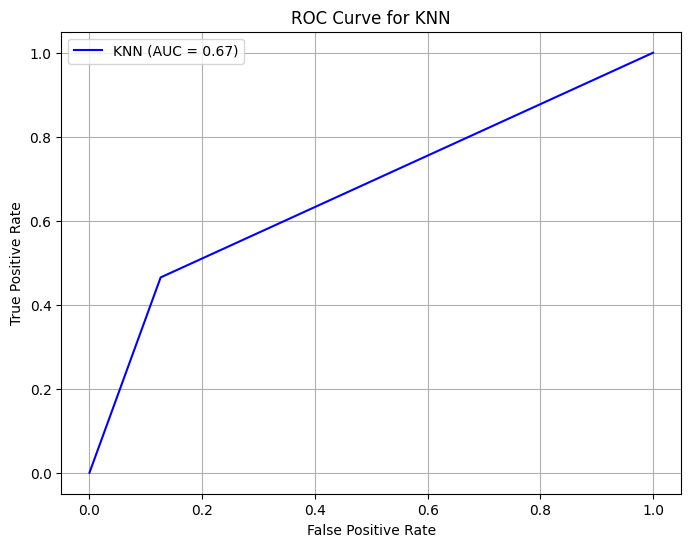

AUC for KNN: 0.67


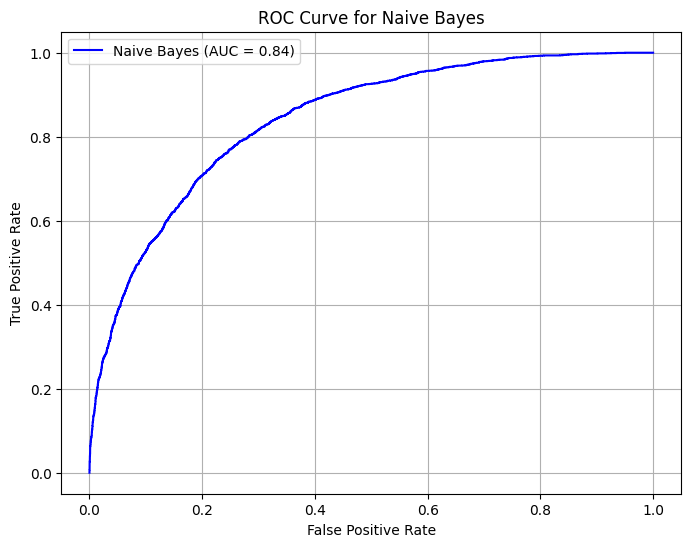

AUC for Naive Bayes: 0.84


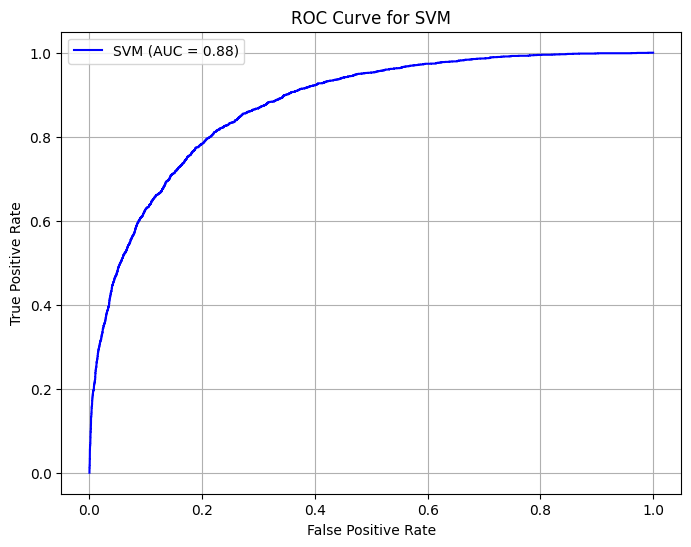

AUC for SVM: 0.88


In [ ]:
plot_roc_auc(best_logreg, X_test_final, y_test, model_name="Logistic Regression")
plot_roc_auc(knn_best, X_test_final, y_test, model_name="KNN")
plot_roc_auc(nb_best, X_test_final, y_test, model_name="Naive Bayes")
plot_roc_auc(svm_best, X_test_final, y_test, model_name="SVM")

Takeaway. Logistic Regression, KNN, and SVM perform similarly in terms of AUC, indicating reliable class separation.
Naive Bayes lags behind, which reflects its simplicity and sensitivity to feature independence assumption.

***Good, 5/5***

# Handling Imbalanced Data

First, let's check the distribution of our target variable to see if there's an imbalance.

RainTomorrow
No     43993
Yes    12427
Name: count, dtype: int64


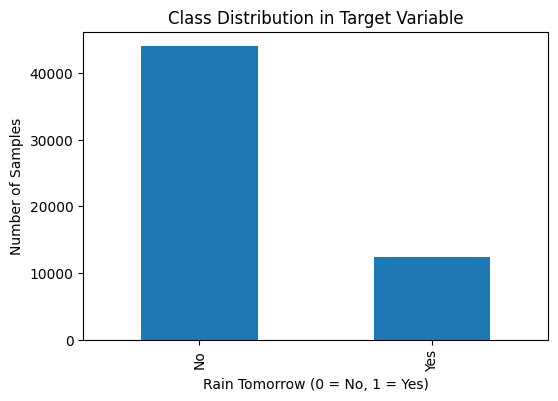

In [ ]:
class_counts = y.value_counts()
print(class_counts)

plt.figure(figsize=(6,4))
class_counts.plot(kind='bar')
plt.title('Class Distribution in Target Variable')
plt.xlabel('Rain Tomorrow (0 = No, 1 = Yes)')
plt.ylabel('Number of Samples')
plt.show()

Takeaway. Class imbalance can affect model performance, especially recall for the minority class.

We'll handle the class imbalance in our dataset using different techniques and actively reuse code through functions.

## Resampling Functions

### Stratified Split

Ensures that each split maintains the same class distribution.

In [ ]:
def stratified_split(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

### Resampling Strategies

Handles class imbalance using different techniques.

In [ ]:
def resample_data(X, y, strategy='none'):
    if strategy == 'undersample':
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X, y)
    elif strategy == 'oversample':
        ros = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X, y)
    elif strategy == 'smote':
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    else:
        X_resampled, y_resampled = X.copy(), y.copy()
    return X_resampled, y_resampled

### Training and Evaluation Function

Trains a model and returns the classification report.

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    return report

## Applying Resampling Strategies

We'll apply different resampling strategies to handle class imbalance and evaluate models accordingly.

In [ ]:
resampling_strategies = ['none', 'undersample', 'oversample', 'smote']
evaluation_results = {}

for strategy in resampling_strategies:
    print(f"\nLogistic Regression with Resampling Strategy: {strategy}")
    X_resampled, y_resampled = resample_data(X_train_final, y_train, strategy=strategy)
    logreg = LogisticRegression(max_iter=1000, solver='liblinear')
    report = train_and_evaluate(logreg, X_resampled, y_resampled, X_test_final, y_test)
    evaluation_results[f'LogReg_{strategy}'] = report

print("\nLogistic Regression with Class Weighting")
logreg_weighted = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
report_weighted = train_and_evaluate(logreg_weighted, X_train_final, y_train, X_test_final, y_test)
evaluation_results['LogReg_weighted'] = report_weighted


Logistic Regression with Resampling Strategy: none

Logistic Regression with Resampling Strategy: undersample

Logistic Regression with Resampling Strategy: oversample

Logistic Regression with Resampling Strategy: smote

Logistic Regression with Class Weighting


KNN with different resampling strategies.

In [ ]:
for strategy in resampling_strategies:
    print(f"\nKNN with Resampling Strategy: {strategy}")
    X_resampled, y_resampled = resample_data(X_train_final, y_train, strategy=strategy)
    knn = KNeighborsClassifier(n_neighbors=1, n_jobs=1)
    report = train_and_evaluate(knn, X_resampled, y_resampled, X_test_final, y_test)
    evaluation_results[f'KNN_{strategy}'] = report


KNN with Resampling Strategy: none

KNN with Resampling Strategy: undersample

KNN with Resampling Strategy: oversample

KNN with Resampling Strategy: smote


Naive Bayes with different resampling strategies.

In [ ]:
for strategy in resampling_strategies:
    print(f"\nNaive Bayes with Resampling Strategy: {strategy}")
    X_resampled, y_resampled = resample_data(X_train_final, y_train, strategy=strategy)
    nb = GaussianNB()
    report = train_and_evaluate(nb, X_resampled, y_resampled, X_test_final, y_test)
    evaluation_results[f'NaiveBayes_{strategy}'] = report


Naive Bayes with Resampling Strategy: none

Naive Bayes with Resampling Strategy: undersample

Naive Bayes with Resampling Strategy: oversample

Naive Bayes with Resampling Strategy: smote


SVM with different resampling strategies.

In [ ]:
for strategy in resampling_strategies:
    print(f"\nSVM with Resampling Strategy: {strategy}")
    X_resampled, y_resampled = resample_data(X_train_final, y_train, strategy=strategy)
    svm = LinearSVC(class_weight=None, max_iter=1000)
    report = train_and_evaluate(svm, X_resampled, y_resampled, X_test_final, y_test)
    evaluation_results[f'SVM_{strategy}'] = report

print("\nSVM with Class Weighting")
svm_weighted = LinearSVC(class_weight='balanced', max_iter=1000)
report_svm_weighted = train_and_evaluate(svm_weighted, X_train_final, y_train, X_test_final, y_test)
evaluation_results['SVM_weighted'] = report_svm_weighted


SVM with Resampling Strategy: none

SVM with Resampling Strategy: undersample

SVM with Resampling Strategy: oversample

SVM with Resampling Strategy: smote

SVM with Class Weighting


# Comprehensive Model Evaluation

Now, we'll automate the creation of a comparison table to evaluate and compare model performances.

Let's define a function to extract metrics.

We'll loop through the `evaluation_results` dictionary, extract the necessary metrics, and create a DataFrame.

In [ ]:
def extract_metrics(report, class_label='1'):
    precision = report.get(class_label, {}).get('precision', 0)
    recall = report.get(class_label, {}).get('recall', 0)
    f1 = report.get(class_label, {}).get('f1-score', 0)
    accuracy = report.get('accuracy', 0)
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}

def compile_evaluation_table(evaluation_results, class_label='1'):
    metrics_list = [
        {'Model': name, **extract_metrics(report, class_label)}
        for name, report in evaluation_results.items()
    ]
    df = pd.DataFrame(metrics_list).set_index('Model')
    return df

evaluation_df = compile_evaluation_table(evaluation_results, class_label='1')
print("\nComprehensive Model Evaluation:")
display(evaluation_df)



Comprehensive Model Evaluation:


,Accuracy,Precision,Recall,F1
Model,,,,
LogReg_none,0.847926,0.719420,0.501820,0.591234
LogReg_undersample,0.806009,0.541112,0.755762,0.630673
LogReg_oversample,0.804147,0.537561,0.761019,0.630064
LogReg_smote,0.834190,0.624277,0.611403,0.617773
LogReg_weighted,0.805300,0.539474,0.762636,0.631932
KNN_none,0.784119,0.508175,0.465022,0.485642
KNN_undersample,0.721464,0.416625,0.676911,0.515791
KNN_oversample,0.784119,0.508175,0.465022,0.485642
KNN_smote,0.779068,0.495961,0.496563,0.496262


We can plot the recall scores to see which models perform better at detecting rain.

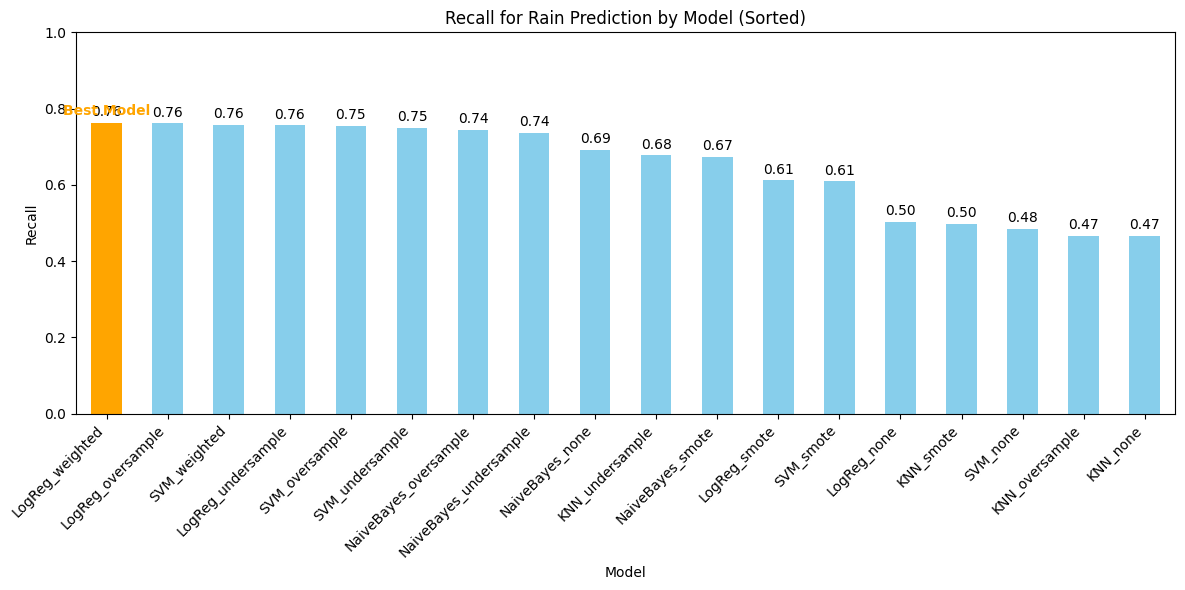

In [ ]:
sorted_evaluation_df = evaluation_df.sort_values(by='Recall', ascending=False)
best_model = sorted_evaluation_df['Recall'].idxmax()
colors = ['orange' if model == best_model else 'skyblue' for model in sorted_evaluation_df.index]

plt.figure(figsize=(12,6))
bars = sorted_evaluation_df['Recall'].plot(kind='bar', color=colors)
plt.title('Recall for Rain Prediction by Model (Sorted)')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.ylim(0,1)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center', va='bottom')

best_index = sorted_evaluation_df.index.tolist().index(best_model)
plt.text(best_index, sorted_evaluation_df['Recall'].max() + 0.02, 'Best Model', ha='center', color='orange', fontweight='bold')

plt.tight_layout()
plt.show()

Takeaway. Handling imbalanced data through under-sampling, over-sampling, weighting, and stratification significantly enhanced the recall of Logistic Regression and SVM models, allowing them to more effectively detect rainy days while slightly reducing precision.
The comprehensive model evaluation revealed that these balancing techniques improved the performance of all models compared to their original versions, demonstrating the critical role of addressing class imbalance in achieving more accurate and reliable predictions.
Logistic Regression with balancing techniques outperformed all other models, achieving the highest recall and effectively detecting the majority of rainy days.

***Great section, although you forgot to use stratified split. 5/5 for smote, 3/5 for weighting and stratification. 10/10 for comprehensive model evaluation.***

# Conclusion

**EDA Findings:**
   
   • Rainfall and weather features showed significant skewness and correlations, leading to feature selection and transformation.
   
   • Handling outliers and multicollinearity improved data quality for modeling.

**Data Preparation:**
   
   • Define features and target.
   
   • Extracted meaningful time-based features from the `Date` column to capture temporal patterns.
   
   • Dropped rows with missing targets to ensure clean data.
   
   • Dropped rows with missing features to allow train-test split without errors.
   
   • Sorted data chronologically and performed a time-based train-test split to prevent data leakage.
   
   • Handled outliers using the IQR method to ensure model robustness.
   
   • Frequency encoding and One-Hot Encoding ensured proper handling of categorical variables.
   
   • Scaling numerical features ensured numerical stability and reduced overfitting risk.

**Metrics and Evaluation:**
   
   • Recall was prioritized due to the goal of detecting rainy days with minimal false negatives.
   
   • ROC-AUC and threshold tuning enhanced model differentiation and performance insights.

**Modeling Insights:**
   
   • Logistic Regression baseline recall was low, but with class weighting and resampling, it achieved the best recall, effectively detecting rainy days.
   
   • Baseline KNN had low recall, but undersampling improved recall significantly. SMOTE slightly enhanced recall.
   
   • Naive Bayes baseline recall was moderate, but undersampling and oversampling achieved higher recall. SMOTE provided a modest recall.
   
   • Baseline SVM had the lowest recall. Resampling and class weighting significantly boosted recall, improving rain detection performance.

**Handling Imbalanced Data:**
   
   • Resampling methods like undersampling and oversampling improved recall across models.
   
   • Class weighting significantly improved recall in Logistic Regression and SVM.

**Comprehensive Evaluation:**
   
   • Logistic Regression with balancing techniques emerged as the best model, achieving the highest recall for rainy days.
   
   • Addressing imbalance was critical to achieving reliable predictions across all models.

### Further Steps to Take

• Threshold Optimization

• Advanced Models

• Deploy Models

• Validation

***Grea conclusion. overall very good work, but try to not drop your data so easily.***